In [ ]:
# Mounting the Drive to Google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/LMCE/instacart-market-basket-analysis.zip" -d "/content/drive/My Drive/Colab Notebooks/LMCE"

In [ ]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/LMCE/aisles.csv.zip" -d "/content/drive/My Drive/Colab Notebooks/LMCE/input"
!unzip -uq "/content/drive/My Drive/Colab Notebooks/LMCE/departments.csv.zip" -d "/content/drive/My Drive/Colab Notebooks/input"
!unzip -uq "/content/drive/My Drive/Colab Notebooks/LMCE/order_products__prior.csv.zip" -d "/content/drive/My Drive/Colab Notebooks/LMCE/input"
!unzip -uq "/content/drive/My Drive/Colab Notebooks/LMCE/order_products__train.csv.zip" -d "/content/drive/My Drive/Colab Notebooks/LMCE/input"
!unzip -uq "/content/drive/My Drive/Colab Notebooks/LMCE/orders.csv.zip" -d "/content/drive/My Drive/Colab Notebooks/LMCE/input"
!unzip -uq "/content/drive/My Drive/Colab Notebooks/LMCE/products.csv.zip" -d "/content/drive/My Drive/Colab Notebooks/LMCE/input"


In [ ]:
import os
#os.rename('unzipped 7 files of instacart dataset', 'input2')
os.chdir("/content/drive/My Drive/Colab Notebooks/LMCE/input2")
print(os.listdir())

['departments.csv', 'aisles.csv', 'products.csv', 'order_products__train.csv', 'orders.csv', 'order_products__prior.csv', '__MACOSX']


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import itertools as iter


In [ ]:
products = pd.read_csv('../input2/products.csv')
aisles = pd.read_csv('../input2/aisles.csv')
departments = pd.read_csv('../input2/departments.csv')
order_products_train = pd.read_csv('../input2/order_products__train.csv')
order_products_prior = pd.read_csv('../input2/order_products__prior.csv')
orders = pd.read_csv('../input2/orders.csv')

In [ ]:
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

In [ ]:
# Function that returns the size of an object in MB
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))
ordersPrior = pd.read_csv('../input/order_products__prior.csv')
print('orders -- dimensions: {0};   size: {1}'.format(ordersPrior.shape, size(ordersPrior)))
display(ordersPrior.head())

orders -- dimensions: (32434489, 4);   size: 1037.90 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
orders = pd.read_csv('../input/orders.csv')
print('orders -- dimensions: {0};   size: {1}'.format(orders.shape, size(orders)))
display(orders.head())

orders -- dimensions: (3421083, 7);   size: 376.24 MB


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
ordersTrain=orders[orders['eval_set']=='train']
print(len(ordersTrain))
train_usr = pd.DataFrame(ordersTrain['user_id'].unique(), columns =['user_id'])
train_usr_sample =  train_usr.sample(2500, random_state=42).sort_values('user_id').reset_index(drop = True)
#print(test_usr_sample)
orders=orders[orders['user_id'].isin(train_usr_sample['user_id'])]
orders.head(5)

131209


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
4564,2006537,284,prior,1,1,12,NaN
4565,983957,284,prior,2,6,11,12.0
4566,2314173,284,prior,3,6,11,14.0
4567,106356,284,prior,4,2,9,10.0
4568,1801937,284,prior,5,2,14,14.0


In [ ]:
Train_data = orders.merge(ordersPrior,how='inner', left_on='order_id', right_on='order_id')

In [ ]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = Train_data.set_index('order_id')['product_id'].rename('item_id')
#orders= orders[orders['user_id']==1]
display(orders.head(5))
type(orders)

order_id
2006537    41376
2006537    24852
2006537    49235
2006537     4812
2006537    19612
Name: item_id, dtype: int64

pandas.core.series.Series

In [ ]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]

In [ ]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100

    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))
    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100

    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)

     # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))
    
    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [ ]:
rules_final= pd.DataFrame()
x=0
rules = association_rules(orders, 0.01)
item_name   = pd.read_csv('../input/products.csv')
item_name1   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_pre_final = merge_item_name(rules, item_name1).sort_values('lift', ascending=False)

Starting order_item:                 410500
Items with support >= 0.01:           10093
Remaining order_item:                386561
Remaining orders with 2+ items:       38504
Remaining order_item:                384212
Item pairs:                         1454287
Item pairs with support >= 0.01:     120658



In [ ]:
display(rules_pre_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,"Yogurt, Sheep Milk, Strawberry",Blueberry Sheep Milk Yogurt,5,0.012986,5,0.012986,6,0.015583,1.000000,0.833333,64.173333
2,Bamba Peanut Snack,Bissli Pizza Flavor Snack,4,0.010389,5,0.012986,5,0.012986,0.800000,0.800000,61.606400
213,Iced Bhakti Chai Coffee Blend,Apple Mango Passion Fruit Fruit Snack,6,0.015583,7,0.018180,6,0.015583,0.857143,1.000000,55.005714
232,Tai Pei Chicken Chow Mein,Chicken Egg Rolls,6,0.015583,7,0.018180,6,0.015583,0.857143,1.000000,55.005714
241,Filet Mignon Canine Cuisine Wet Dog Food,Dog Food With Beef in Meaty Juices,5,0.012986,7,0.018180,5,0.012986,0.714286,1.000000,55.005714
...,...,...,...,...,...,...,...,...,...,...,...
17886,Large Lemon,Organic Lemon,4,0.010389,1899,4.931955,1074,2.789321,0.002106,0.003724,0.000755
9263,Blueberries,Bag of Organic Bananas,7,0.018180,801,2.080303,4745,12.323395,0.008739,0.001475,0.000709
23971,Strawberries,Organic Strawberries,6,0.015583,1624,4.217744,3402,8.835446,0.003695,0.001764,0.000418
6405,Bag of Organic Bananas,Banana,7,0.018180,4745,12.323395,5912,15.354249,0.001475,0.001184,0.000096


In [ ]:
def merge_item_name(rules, item_name):
    columns = ['item_A','item_B','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name, left_on='item_A', right_on='product_id')
                .merge(item_name, left_on='item_B', right_on='product_id'))
   # print(rules)
    return rules[columns]

rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,1337,7922,5,0.012986,5,0.012986,6,0.015583,1.000000,0.833333,64.173333
2,16668,19064,4,0.010389,5,0.012986,5,0.012986,0.800000,0.800000,61.606400
213,22864,3567,6,0.015583,7,0.018180,6,0.015583,0.857143,1.000000,55.005714
232,21640,20739,6,0.015583,7,0.018180,6,0.015583,0.857143,1.000000,55.005714
241,16096,42305,5,0.012986,7,0.018180,5,0.012986,0.714286,1.000000,55.005714
...,...,...,...,...,...,...,...,...,...,...,...
17886,47626,5876,4,0.010389,1899,4.931955,1074,2.789321,0.002106,0.003724,0.000755
9263,9076,13176,7,0.018180,801,2.080303,4745,12.323395,0.008739,0.001475,0.000709
23971,16797,21137,6,0.015583,1624,4.217744,3402,8.835446,0.003695,0.001764,0.000418
6405,13176,24852,7,0.018180,4745,12.323395,5912,15.354249,0.001475,0.001184,0.000096


In [ ]:
rules_final.to_csv("Apriori.csv")

In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left', on = 'department_id'), right=aisles, how='left', on = 'aisle_id')
Train_data = orders.merge(order_products_prior,how='inner', left_on='order_id', right_on='order_id').drop(columns=['eval_set'])
Train_data = Train_data.merge(items,how='inner', left_on='product_id', right_on='product_id')
Train_data.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2539329,1,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
1,2398795,1,2,3,7,15.0,196,1,1,Soda,77,7,beverages,soft drinks
2,473747,1,3,3,12,21.0,196,1,1,Soda,77,7,beverages,soft drinks
3,2254736,1,4,4,7,29.0,196,1,1,Soda,77,7,beverages,soft drinks
4,431534,1,5,4,15,28.0,196,1,1,Soda,77,7,beverages,soft drinks


In [ ]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
##MISSING DATA
total = Train_data.isnull().sum().sort_values(ascending=False)
total
percent = (Train_data.isnull().sum()/Train_data.isnull().count()).sort_values(ascending=False)
percent
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
days_since_prior_order,2078068,0.06407
aisle,0,0.00000
department,0,0.00000
department_id,0,0.00000
aisle_id,0,0.00000
product_name,0,0.00000
reordered,0,0.00000
add_to_cart_order,0,0.00000
product_id,0,0.00000
order_hour_of_day,0,0.00000


In [ ]:
#most ordered products
prod_f = order_products_all.groupby("product_id")["reordered"].size().reset_index(name='Total_reorders')
prod_f = pd.merge(prod_f, products[['product_id', 'product_name']], how='left', on=['product_id'])
prod_f = prod_f.sort_values(by='Total_reorders', ascending=False)[:10]
prod_f

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


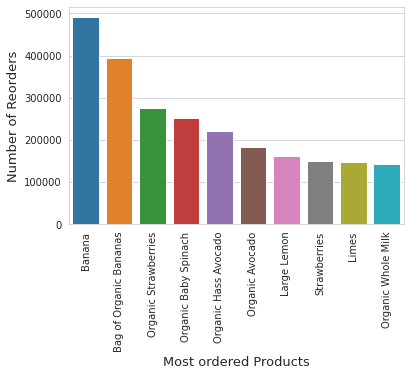

In [ ]:

prod_f  = prod_f.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)
sns.set_style('whitegrid')
plt.xticks(rotation='vertical')
sns.barplot(prod_f.index, prod_f.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()